## Generative Modelling of Insulin Proteins - 02456 Deep Learning DTU

**Jonas Vestergaard Jensen, s162615 & Emma Ahrensbach Rørbeck, s173733**

### Setup

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.utils import get_repo_dir, get_device, set_seeds, load_pickle_obj
from src.models import GruNet, LstmNet, WaveNetX, TransformerModel, test_model
from src.visualization import plot_learning_curves, perplexity_box_plot, embedding_plot, similarity_plot

In [2]:
# Set seeds
seed = 42
set_seeds(seed)
# Root directory of GitHub directory
repo_dir = get_repo_dir()
# Cuda device
device = get_device()

In [3]:
# Load pre-trained models
lstm_model = torch.load(os.path.join(repo_dir, 'models/LSTM_pytorch_model.pt'), map_location=device)
gru_model = torch.load(os.path.join(repo_dir, 'models/GRU_pytorch_model.pt'), map_location=device)
transformer_model = torch.load(os.path.join(repo_dir, 'models/Transformer_pytorch_model.pt'), map_location=device)
wavenet_model = torch.load(os.path.join(repo_dir, 'models/WaveNet_pytorch_model.pt'), map_location=device)

# Load dictionaries with model statistics
lstm_stats_dict = load_pickle_obj(os.path.join(repo_dir, 'models/LSTM_stats_dict.pickle'))
gru_stats_dict = load_pickle_obj(os.path.join(repo_dir, 'models/GRU_stats_dict.pickle'))
transformer_stats_dict = load_pickle_obj(os.path.join(repo_dir, 'models/Transformer_stats_dict.pickle'))
wavenet_stats_dict = load_pickle_obj(os.path.join(repo_dir, 'models/WaveNet_stats_dict.pickle'))

In [4]:
# Set models to evaluation model
lstm_model.eval();
gru_model.eval();
transformer_model.eval();
wavenet_model.eval();

### Learning curves

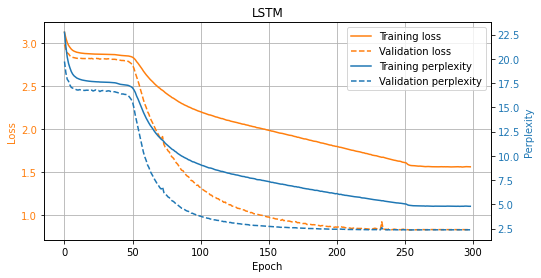

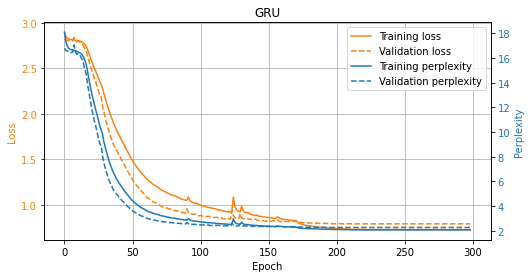

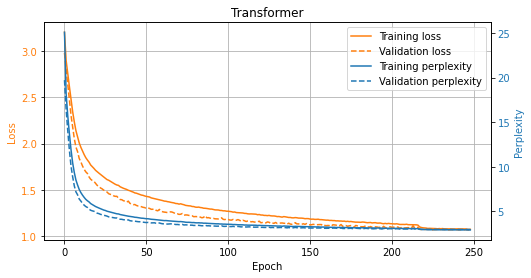

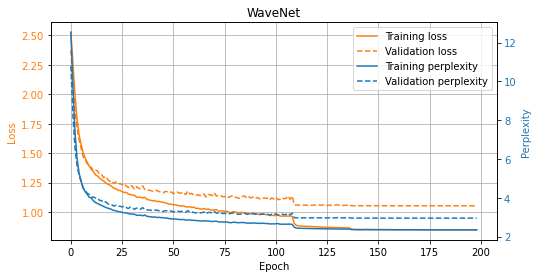

In [5]:
# Create figures
lstm_learning_curves = plot_learning_curves(lstm_stats_dict, 'LSTM')
gru_learning_curves = plot_learning_curves(gru_stats_dict, 'GRU')
transformer_learning_curves = plot_learning_curves(transformer_stats_dict, 'Transformer')
wavenet_learning_curves = plot_learning_curves(wavenet_stats_dict, 'WaveNet')

# Show figures
lstm_learning_curves.show()
gru_learning_curves.show()
transformer_learning_curves.show()
wavenet_learning_curves.show()

### Test models

In [6]:
# Load test data
df_test = pd.read_csv(os.path.join(repo_dir, 'data/processed/test_data.txt'),
    sep='\t', dtype='str')

# Get test results
lstm_test_results = test_model(lstm_stats_dict, lstm_model, df_test, device)
gru_test_results = test_model(gru_stats_dict, gru_model, df_test, device)
transformer_test_results = test_model(transformer_stats_dict, transformer_model, df_test, device)
wavenet_test_results = test_model(wavenet_stats_dict, wavenet_model, df_test, device)

### Box plot of test perplexities

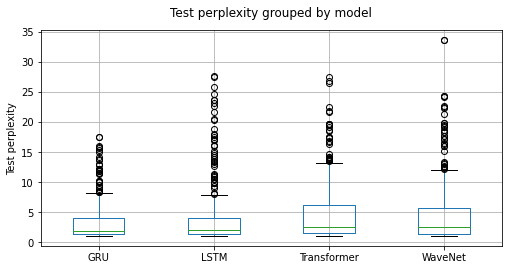

In [7]:
box_plot = perplexity_box_plot([lstm_test_results['perplexity'].to_numpy()[:, np.newaxis],
                                gru_test_results['perplexity'].to_numpy()[:, np.newaxis],
                                transformer_test_results['perplexity'].to_numpy()[:, np.newaxis],
                                wavenet_test_results['perplexity'].to_numpy()[:, np.newaxis]],
                                ['LSTM', 'GRU', 'Transformer', 'WaveNet'])
box_plot.show()

In [8]:
# Average perplexities of models
print('LSTM avg. perplexity:', lstm_test_results['perplexity'].mean())
print('GRU avg. perplexity:', gru_test_results['perplexity'].mean())
print('Transformer avg. perplexity:', transformer_test_results['perplexity'].mean())
print('WaveNet avg. perplexity:', wavenet_test_results['perplexity'].mean())


LSTM avg. perplexity: 4.142019592654835
GRU avg. perplexity: 3.4679739075882665
Transformer avg. perplexity: 4.649293174079812
WaveNet avg. perplexity: 4.6144198350857195


### Sequence embeddings


In [9]:
# Get embeddings of test sequences from test results
emb_lstm = lstm_test_results.loc[:, lstm_test_results.columns.str.startswith('emb_1_')]
emb_gru = gru_test_results.loc[:, gru_test_results.columns.str.startswith('emb_1_')]
emb_transformer = transformer_test_results.loc[:, transformer_test_results.columns.str.startswith('emb_1_')]
emb_wavenet = wavenet_test_results.loc[:, wavenet_test_results.columns.str.startswith('emb_1_')]

emb_lstm = emb_lstm.to_numpy()
emb_gru = emb_gru.to_numpy()
emb_transformer = emb_transformer.to_numpy()
emb_wavenet = emb_wavenet.to_numpy()

# Project embeddings to 2-dimensional space
X_emb_lstm = TSNE(n_components=2, random_state=seed).fit_transform(emb_lstm)
X_emb_gru = TSNE(n_components=2, random_state=seed).fit_transform(emb_gru)
X_emb_transformer = TSNE(n_components=2, random_state=seed).fit_transform(emb_transformer)
X_emb_wavenet = TSNE(n_components=2, random_state=seed).fit_transform(emb_wavenet)

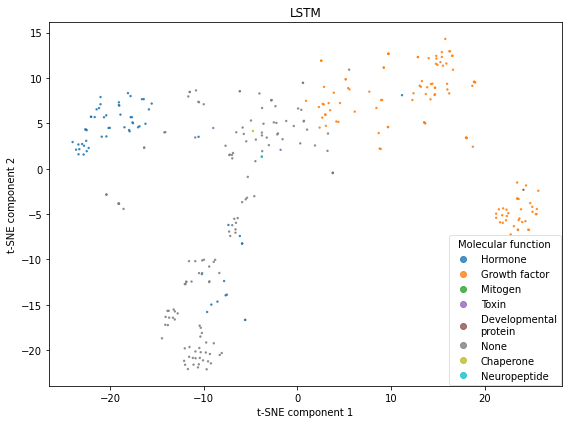

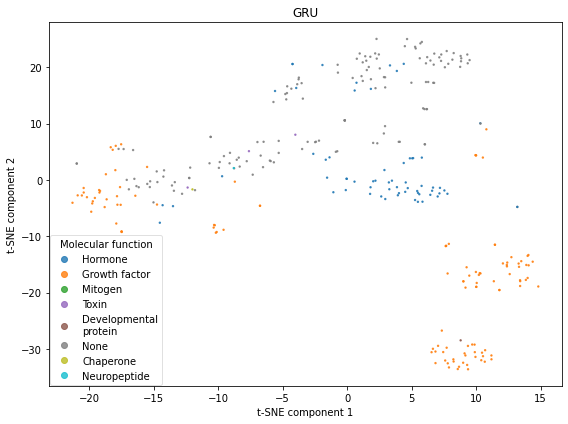

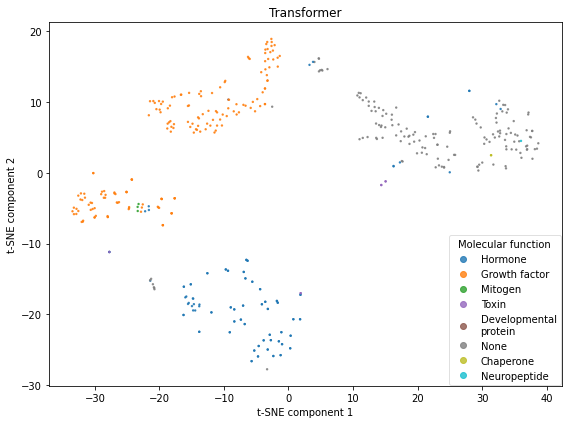

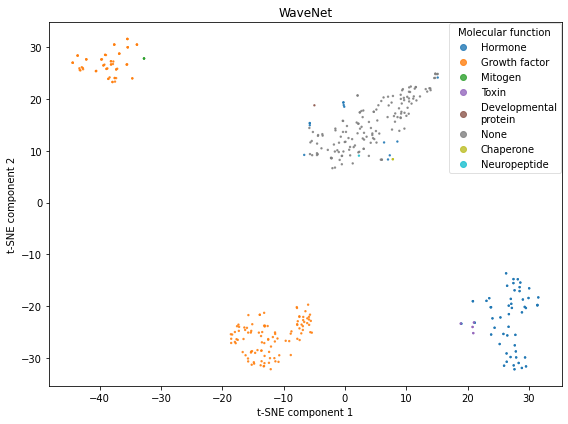

In [10]:
# Create figures of embeddings
emb_plot_lstm = embedding_plot(X_emb_lstm, lstm_test_results, 'LSTM')
emb_plot_gru = embedding_plot(X_emb_gru, gru_test_results, 'GRU')
emb_plot_transformer = embedding_plot(X_emb_transformer, transformer_test_results, 'Transformer')
emb_plot_wavenet = embedding_plot(X_emb_wavenet, wavenet_test_results, 'WaveNet')

# Show figures
emb_plot_lstm.show()
emb_plot_gru.show()
emb_plot_transformer.show()
emb_plot_wavenet.show()


### Protein generation


In [11]:
# Load generation results
# (these take quite a while to generate - src/models/generate_with_model.py)
lstm_gen_results = np.load(os.path.join(
        repo_dir, 'models/LSTM_similarity_scores_generation.npy'))
lstm_mut_results = np.load(os.path.join(
        repo_dir, 'models/LSTM_similarity_scores_mutation.npy'))
gru_gen_results = np.load(os.path.join(
        repo_dir, 'models/GRU_similarity_scores_generation.npy'))
gru_mut_results = np.load(os.path.join(
        repo_dir, 'models/GRU_similarity_scores_mutation.npy'))
transformer_gen_results = np.load(os.path.join(
        repo_dir, 'models/Transformer_similarity_scores_generation.npy'))
transformer_mut_results = np.load(os.path.join(
        repo_dir, 'models/Transformer_similarity_scores_mutation.npy'))
wavenet_gen_results = np.load(os.path.join(
        repo_dir, 'models/WaveNet_similarity_scores_generation.npy'))
wavenet_mut_results = np.load(os.path.join(
        repo_dir, 'models/WaveNet_similarity_scores_mutation.npy'))

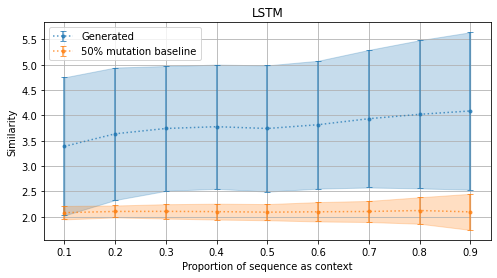

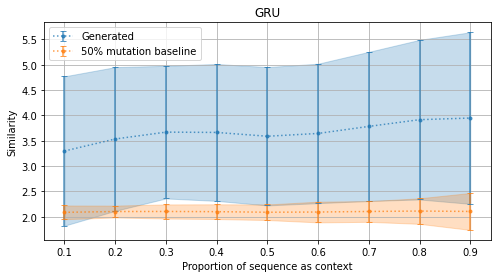

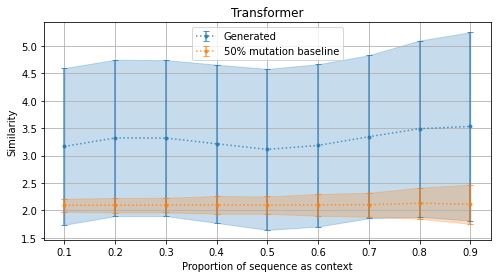

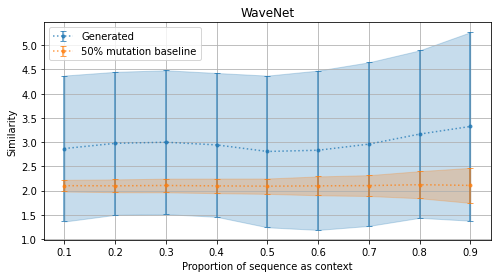

In [12]:
# Create figures
context_props = np.arange(0.1, 1, 0.1)
mutation_rate = 0.5
lstm_similarity_plot = similarity_plot(context_props, mutation_rate, 'LSTM',
        lstm_gen_results, lstm_mut_results)
gru_similarity_plot = similarity_plot(context_props, mutation_rate, 'GRU',
        gru_gen_results, gru_mut_results)
transformer_similarity_plot = similarity_plot(context_props, mutation_rate, 'Transformer',
        transformer_gen_results, transformer_mut_results)
wavenet_similarity_plot = similarity_plot(context_props, mutation_rate, 'WaveNet',
        wavenet_gen_results, wavenet_mut_results)

# Show figures
lstm_similarity_plot.show()
gru_similarity_plot.show()
transformer_similarity_plot.show()
wavenet_similarity_plot.show()